Enter the molecule/atom (NaI, KI, SiO2, SO2):  SO2
Enter the number of particles for SO2:  1e35


{
    "Fundamentals": {
        "ExomoonSource": true,
        "DopplerPlanetRotation": false,
        "CLV_variations": false,
        "RM_effect": false,
        "DopplerOrbitalMotion": true
    },
    "Architecture": {
        "planetName": "L98-59b",
        "R_moon": 182200000.0,
        "a_moon": 9700000000.0,
        "starting_orbphase_moon": 1.5707963267948966
    },
    "Scenarios": {
        "exomoon": {
            "q_moon": 4.34
        }
    },
    "Species": {
        "exomoon": {
            "SO2": {
                "T": 1000,
                "Nparticles": 1e+35
            }
        }
    },
    "Grids": {
        "lower_w": 0.00015,
        "upper_w": 0.00095,
        "resolutionLow": 1e-06,
        "widthHighRes": 1e-05,
        "resolutionHigh": 1e-06,
        "x_midpoint": 727056000000.0,
        "x_border": 532638000000.0,
        "x_steps": 50.0,
        "phi_steps": 50.0,
        "rho_steps": 50.0,
        "upper_rho": 62292000000.0,
        "orbphase_border": 0.

/Users/raghavchari/Desktop/Integrated_Code/Prometheus/pythonScripts/celestialBodies.py:148: RuntimeWarning: invalid value encountered in sqrt
  arg = 1. - np.sqrt(1. - rho**2 / self.R**2)



PROMETHEUS finished, yay! Elapsed time is: -1 day, 23:59:59.999956
The maximal flux decrease due to atmospheric/exospheric absorption in percent is: nan
The minimal flux decrease due to atmospheric/exospheric absorption in percent is: nan


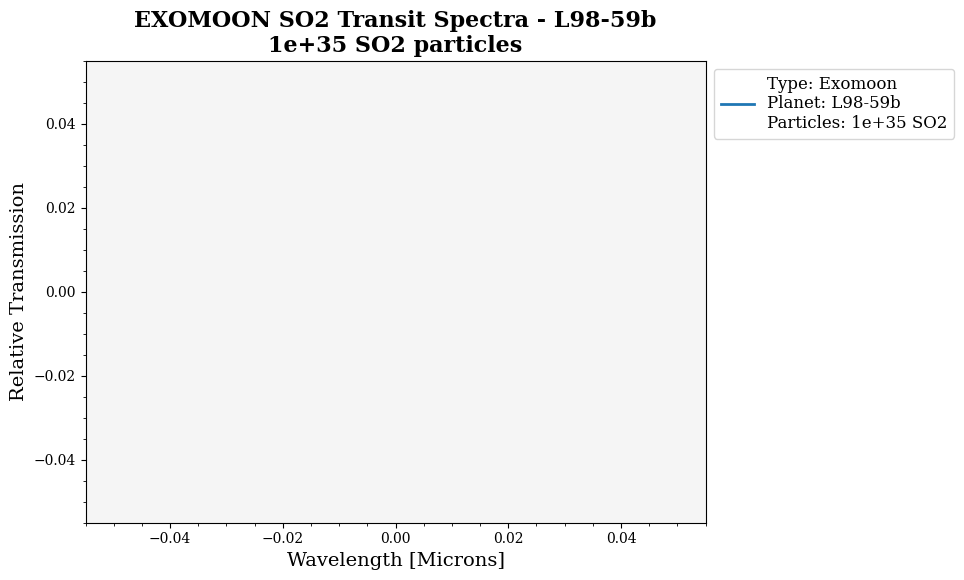

In [7]:
import importlib
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
from scipy.special import wofz
import Prometheus.pythonScripts.gasProperties as gasprop
import Prometheus.pythonScripts.celestialBodies as bodies
import Prometheus.pythonScripts.geometryHandler as geom
import Prometheus.pythonScripts.constants as const

importlib.reload(gasprop)
importlib.reload(bodies)

def get_params(element, Nparticles):
    base_params = {
        "Fundamentals": {
            "ExomoonSource": True,
            "DopplerPlanetRotation": False,
            "CLV_variations": False,
            "RM_effect": False,
            "DopplerOrbitalMotion": True
        },
        "Architecture": {
            "planetName": "L98-59b",
            "R_moon": 182200000.0,
            "a_moon": 9700000000.0,#14238769799.999998,
            "starting_orbphase_moon": 1.5707963267948966
        },
        "Scenarios": {
            "exomoon": {
                "q_moon": 4.34
            }
        },
        "Species": {
            "exomoon": {
                element: {
                    "T": 1000,
                    "Nparticles": Nparticles
                }
            }
        },
        "Grids": {
            "lower_w": 1.5e-4,
            "upper_w": 9.5e-4,
            "resolutionLow": 0.01e-4,
            "widthHighRes": 0.1e-4,
            "resolutionHigh": 0.01e-4,
            "x_midpoint": 727056000000.0,
            "x_border": 532638000000.0,
            "x_steps": 50.0,
            "phi_steps": 50.0,
            "rho_steps": 50.0,
            "upper_rho": 62292000000.0,
            "orbphase_border": 0.,
            "orbphase_steps": 1.
        }
    }
    
    
    if element == "NaI":
        base_params["Species"]["exomoon"][element]["sigma_v"] = 2083248.5238854631
        base_params["Grids"]["lower_w"] = 1.5e-4
        base_params["Grids"]["upper_w"] = 9.5e-4
        base_params["Grids"]["resolutionLow"] = 1e-08
        base_params["Grids"]["widthHighRes"] = 7.500000000000001e-09
        base_params["Grids"]["resolutionHigh"] = 1e-09
        base_params["Grids"]["x_steps"] = 50.0
        base_params["Grids"]["phi_steps"] = 50.0
        base_params["Grids"]["rho_steps"] = 50.0
        base_params["Grids"]["orbphase_border"] = 1.5707963267948966
        base_params["Grids"]["orbphase_steps"] = 50.0
    elif element == "SiO2":
        base_params["Species"]["exomoon"][element]["T"] = 1000.0
        base_params["Fundamentals"]["DopplerOrbitalMotion"] = True
        base_params["Grids"]["lower_w"] = 7e-4
        base_params["Grids"]["upper_w"] = 12e-4
    elif element == "KI":
        base_params["Species"]["exomoon"][element]["sigma_v"] = 1543288.733835272
        base_params["Architecture"]["a_moon"] = 17310735000.0
        base_params["Scenarios"]["exomoon"]["q_moon"] = 4.4
        base_params["Grids"]["lower_w"] = 7.665e-05
        base_params["Grids"]["upper_w"] = 7.703e-05
        base_params["Grids"]["resolutionLow"] = 1e-08
        base_params["Grids"]["widthHighRes"] = 7.500000000000001e-09
        base_params["Grids"]["resolutionHigh"] = 1e-09
        base_params["Grids"]["x_steps"] = 50.0
        base_params["Grids"]["phi_steps"] = 50.0
        base_params["Grids"]["rho_steps"] = 50.0
        base_params["Grids"]["orbphase_border"] = 1.5707963267948966
        base_params["Grids"]["orbphase_steps"] = 50.0
    return base_params

def voigt_profile(x, sigma, gamma):
    """ Voigt profile implementation """
    z = (x + 1j * gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

def extract_information(data, element):
    planet_name = data["Architecture"]["planetName"]
    n_particles = data["Species"]["exomoon"][element]["Nparticles"]
    return planet_name, n_particles

def plot_spectrum(file_path, element, planet_name, n_particles):
    # Read data from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    modified_lines = lines[4:]
    x_data = []
    y_data = [[] for _ in range(1)]
    
    for line in modified_lines:
        values = line.strip().split()
        x_data.append(float(values[0]) * 10000)  # Converting to microns here 
        for i in range(1):
            y_data[i].append((1 - float(values[i + 1])) * 1)  # Converting to ppm here
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    
    ax.plot(x_data, y_data[0], linewidth=2)
   
    title_text = f'EXOMOON {element} Transit Spectra - {planet_name}\n' \
                 f'{n_particles} {element} particles'
    ax.set_title(title_text, fontsize=16, fontweight='bold')
    
    ax.set_xlabel('Wavelength [Microns]', fontsize=14)
    ax.set_ylabel('Relative Transmission', fontsize=14)
    
    ax.set_yscale('linear')
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.minorticks_on()
   
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    
    legend_label = f'Type: Exomoon\nPlanet: {planet_name}\nParticles: {n_particles} {element}'
    ax.legend([legend_label], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    
    plt.rcParams['font.family'] = 'serif'
    
    plt.show()

# Input from the user
element = input("Enter the molecule/atom (NaI, KI, SiO2, SO2): ")
Nparticles = float(input(f"Enter the number of particles for {element}: "))

params = get_params(element, Nparticles)

params_json = json.dumps(params, indent=4)
print(params_json)

fundamentalsDict = params['Fundamentals']
scenarioDict = params['Scenarios']
architectureDict = params['Architecture']
speciesDict = params['Species']
gridsDict = params['Grids']

planet = bodies.AvailablePlanets().findPlanet(architectureDict['planetName'])

wavelengthGrid = gasprop.WavelengthGrid(gridsDict['lower_w'], gridsDict['upper_w'], gridsDict['widthHighRes'], gridsDict['resolutionLow'], gridsDict['resolutionHigh'])
spatialGrid = geom.Grid(gridsDict['x_midpoint'], gridsDict['x_border'], int(gridsDict['x_steps']), gridsDict['upper_rho'], int(gridsDict['rho_steps']),
                        int(gridsDict['phi_steps']), gridsDict['orbphase_border'], int(gridsDict['orbphase_steps']))

scenarioList = []

for key_scenario in scenarioDict.keys():
    if key_scenario == 'barometric':
        scenarioList.append(gasprop.BarometricAtmosphere(scenarioDict['barometric']['T'], scenarioDict['barometric']['P_0'], scenarioDict['barometric']['mu'], planet))
    elif key_scenario == 'hydrostatic':
        scenarioList.append(gasprop.HydrostaticAtmosphere(scenarioDict['hydrostatic']['T'], scenarioDict['hydrostatic']['P_0'], scenarioDict['hydrostatic']['mu'], planet))
    elif key_scenario == 'powerLaw':
        if 'P_0' in scenarioDict['powerLaw'].keys():
            scenarioList.append(gasprop.PowerLawAtmosphere(scenarioDict['powerLaw']['T'], scenarioDict['powerLaw']['P_0'], scenarioDict['powerLaw']['q_esc'], planet))
        else:
            key_species = list(speciesDict['powerLaw'].keys())[0]  # Only one absorber
            Nparticles = speciesDict['powerLaw'][key_species]['Nparticles']
            scenarioList.append(gasprop.PowerLawExosphere(Nparticles, scenarioDict['powerLaw']['q_esc'], planet))
    elif key_scenario == 'exomoon':
        moon = bodies.Moon(architectureDict['starting_orbphase_moon'], architectureDict['R_moon'], architectureDict['a_moon'], planet)
        key_species = list(speciesDict['exomoon'].keys())[0]  # Only one absorber
        Nparticles = speciesDict['exomoon'][key_species]['Nparticles']
        scenarioList.append(gasprop.MoonExosphere(Nparticles, scenarioDict['exomoon']['q_moon'], moon))
    elif key_scenario == 'torus':
        key_species = list(speciesDict['torus'].keys())[0]  # Only one absorber
        Nparticles = speciesDict['torus'][key_species]['Nparticles']
        scenarioList.append(gasprop.TorusExosphere(Nparticles, scenarioDict['torus']['a_torus'], scenarioDict['torus']['v_ej'], planet))
    elif key_scenario == 'serpens':
        key_species = list(speciesDict['serpens'].keys())[0]  # Only one absorber
        Nparticles = speciesDict['serpens'][key_species]['Nparticles']
        scenario = gasprop.SerpensExosphere(scenarioDict['serpens']['serpensPath'], Nparticles, planet, 0.)
        scenario.addInterpolatedDensity(spatialGrid)
        scenarioList.append(scenario)  # sigmaSmoothing hardcoded to 0, i.e. no Gaussian smoothing of the serpens density distribution.

for idx, key_scenario in enumerate(scenarioDict.keys()):
    for key_species in speciesDict[key_scenario].keys():
        absorberDict = speciesDict[key_scenario][key_species]
        if key_species in const.AvailableSpecies().listSpeciesNames():  # Atom/ion
            if 'chi' in absorberDict:
                scenarioList[idx].addConstituent(key_species, absorberDict['chi'])
                scenarioList[idx].constituents[-1].addLookupFunctionToConstituent(wavelengthGrid)
            elif 'sigma_v' in absorberDict:
                scenarioList[idx].addConstituent(key_species, absorberDict['sigma_v'])
                scenarioList[idx].constituents[-1].addLookupFunctionToConstituent(wavelengthGrid)
        else:
            # Handle molecular species without opacity data
            scenarioList[idx].addMolecularConstituent(key_species, absorberDict['T'])
            scenarioList[idx].constituents[-1].addLookupFunctionToConstituent()

atmos = gasprop.Atmosphere(scenarioList, fundamentalsDict['DopplerOrbitalMotion'])

main = gasprop.Transit(atmos, wavelengthGrid, spatialGrid)
main.addWavelength()

R = main.sumOverChords()
wavelength = wavelengthGrid.constructWavelengthGrid(scenarioList)
orbphase = spatialGrid.constructOrbphaseAxis()

orbphaseOutput = np.insert(orbphase / (2. * np.pi), 0, np.nan)
mainOutput = np.vstack((wavelength, R))
output = np.vstack((orbphaseOutput, mainOutput.T))

header = 'Prometheus output file.\nFirst row: Orbital phases [1]\nAll other rows: Wavelength [cm] (first column), Transit depth R(orbital phase, wavelength) [1] (other columns)'

output_dir = os.path.join(os.getcwd(), 'output')
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, f'{element}.txt')
np.savetxt(output_file_path, output, header=header)

elapsedTime = datetime.now() - datetime.now()

print("\nPROMETHEUS finished, yay! Elapsed time is:", elapsedTime)
print("The maximal flux decrease due to atmospheric/exospheric absorption in percent is:", np.abs(np.round(100 * (1 - np.min(R)), 10)))
print("The minimal flux decrease due to atmospheric/exospheric absorption in percent is:", np.abs(np.round(100 * (1 - np.max(R)), 10)))

planet_name, n_particles = extract_information(params, element)

plot_spectrum(output_file_path, element, planet_name, n_particles)


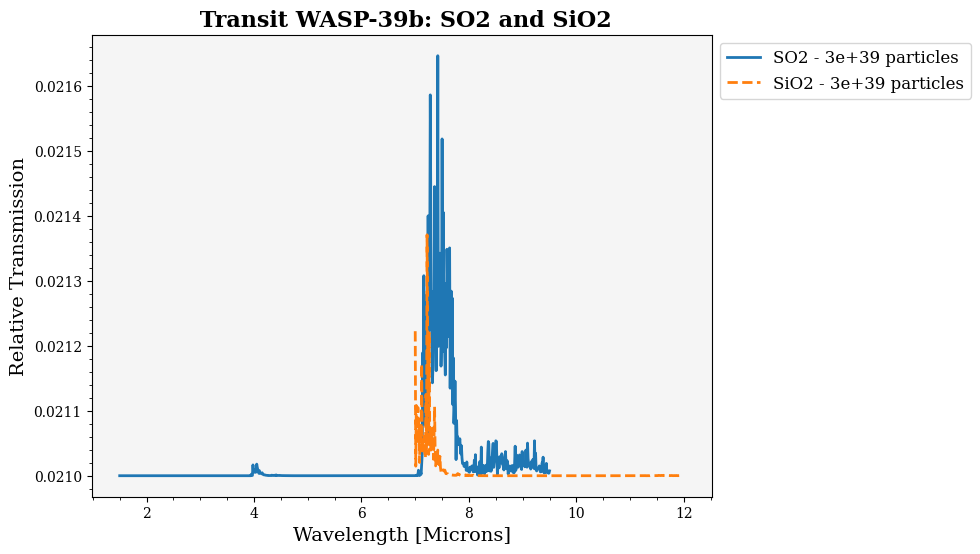

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter
import os

C_Wasp39 = 0.001400000000000002

def read_spectrum(file_path):
    """Reads spectrum data from a file and returns wavelength and transmission arrays."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    modified_lines = lines[4:]
    x_data = []
    y_data = []
    
    for line in modified_lines:
        values = line.strip().split()
        x_data.append((float(values[0]) * 10000) + 0)  # Convert to microns
        y_data.append(((1 - float(values[1])) * 1)+C_Wasp39)  # Convert to relative transmission

    return np.array(x_data), np.array(y_data)

def overlay_plots(file_path1, file_path2, element1, element2, planet_name1, planet_name2, n_particles1, n_particles2):
    """Overlays two spectra on a single plot."""
    x_data1, y_data1 = read_spectrum(file_path1)
    x_data2, y_data2 = read_spectrum(file_path2)
 
    

    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    
    # Plot the first dataset
    ax.plot(x_data1, y_data1, label=f'{element1} - {n_particles1} particles', linewidth=2)
    
    # Plot the second dataset
    ax.plot(x_data2, y_data2, label=f'{element2} - {n_particles2} particles', linewidth=2, linestyle='--')
    
    # Set plot titles and labels
    title_text = f' Transit WASP-39b: {element1} and {element2}'
    ax.set_title(title_text, fontsize=16, fontweight='bold')
    ax.set_xlabel('Wavelength [Microns]', fontsize=14)
    ax.set_ylabel('Relative Transmission', fontsize=14)
    
    # Format the y-axis
    ax.set_yscale('linear')
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.minorticks_on()

    # Customize background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')

    # Add the legend
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    
    plt.rcParams['font.family'] = 'serif'
    
    # Show plot
    plt.show()

# Example of how to call the overlay function
file_path1 = os.path.join(os.getcwd(), 'output', 'SO2.txt')  # Path to first spectrum file
file_path2 = os.path.join(os.getcwd(), 'output', 'SiO2.txt')  # Path to second spectrum file

# Replace with actual values or extract them from params
element1 = "SO2"
element2 = "SiO2"
planet_name1 = "WASP-39b"
planet_name2 = "WASP-39b"
n_particles1 = 3e39
n_particles2 = 3e39

overlay_plots(file_path1, file_path2, element1, element2, planet_name1, planet_name2, n_particles1, n_particles2)


Enter the first molecule/atom (NaI, KI, SiO2, SO2):  SiO2
Enter the second molecule/atom (NaI, KI, SiO2, SO2):  SO2
Enter the total number of particles for the mixture:  1e35


{
    "Fundamentals": {
        "ExomoonSource": true,
        "DopplerPlanetRotation": false,
        "CLV_variations": false,
        "RM_effect": false,
        "DopplerOrbitalMotion": true
    },
    "Architecture": {
        "planetName": "WASP-39b",
        "R_moon": 182200000.0,
        "a_moon": 15890367000.0,
        "starting_orbphase_moon": 1.5707963267948966
    },
    "Scenarios": {
        "exomoon": {
            "q_moon": 4.34
        }
    },
    "Species": {
        "exomoon": {
            "SiO2": {
                "T": 1000.0,
                "Nparticles": 5e+34
            },
            "SO2": {
                "T": 1000,
                "Nparticles": 5e+34
            }
        }
    },
    "Grids": {
        "lower_w": 0.0007,
        "upper_w": 0.0012,
        "resolutionLow": 1e-06,
        "widthHighRes": 1e-05,
        "resolutionHigh": 1e-06,
        "x_midpoint": 727056000000.0,
        "x_border": 532638000000.0,
        "x_steps": 50.0,
        "phi_step

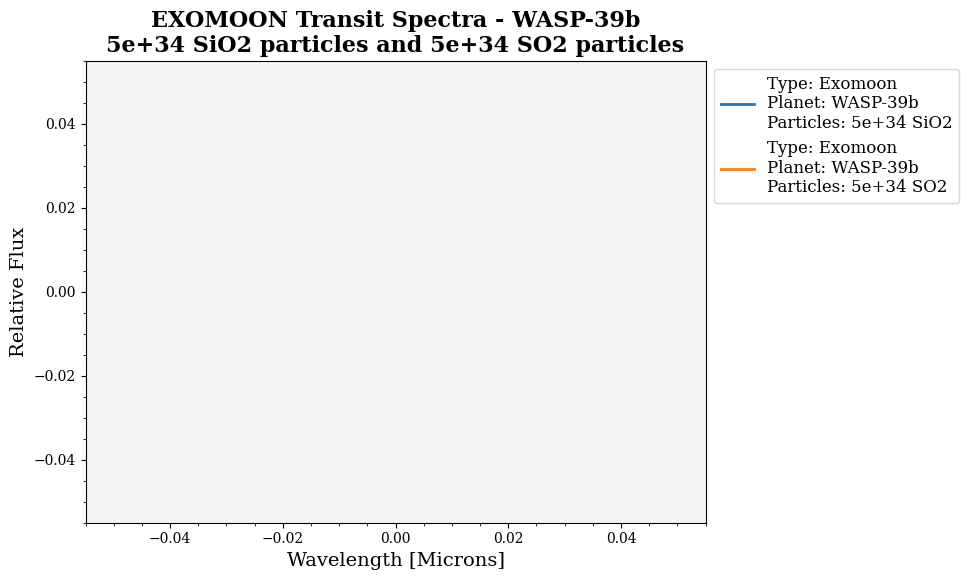

In [4]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
from scipy.special import wofz
import Prometheus.pythonScripts.gasProperties as gasprop
import Prometheus.pythonScripts.celestialBodies as bodies
import Prometheus.pythonScripts.geometryHandler as geom
import Prometheus.pythonScripts.constants as const

# Ensure necessary modules are reloaded
import importlib
importlib.reload(gasprop)
importlib.reload(bodies)

def get_params(elements, Nparticles_list):
    base_params = {
        "Fundamentals": {
            "ExomoonSource": True,
            "DopplerPlanetRotation": False,
            "CLV_variations": False,
            "RM_effect": False,
            "DopplerOrbitalMotion": True
        },
        "Architecture": {
            "planetName": "WASP-39b",
            "R_moon": 182200000.0,
            "a_moon": 15890367000.0,
            "starting_orbphase_moon": 1.5707963267948966
        },
        "Scenarios": {
            "exomoon": {
                "q_moon": 4.34
            }
        },
        "Species": {
            "exomoon": {}
        },
        "Grids": {
            "lower_w": 1.5e-7,
            "upper_w": 9.5e-7,
            "resolutionLow": 0.01e-4,
            "widthHighRes": 0.1e-4,
            "resolutionHigh": 0.01e-4,
            "x_midpoint": 727056000000.0,
            "x_border": 532638000000.0,
            "x_steps": 50.0,
            "phi_steps": 50.0,
            "rho_steps": 50.0,
            "upper_rho": 62292000000.0,
            "orbphase_border": 0.,
            "orbphase_steps": 1.
        }
    }
    
    for element, Nparticles in zip(elements, Nparticles_list):
        base_params["Species"]["exomoon"][element] = {
            "T": 1000,
            "Nparticles": Nparticles
        }
        
        if element == "NaI":
            base_params["Species"]["exomoon"][element]["sigma_v"] = 2000000.0
            base_params["Grids"]["lower_w"] = 5.888e-05
            base_params["Grids"]["upper_w"] = 5.898e-05
        elif element == "SiO2":
            base_params["Species"]["exomoon"][element]["T"] = 1000.0
            base_params["Fundamentals"]["DopplerOrbitalMotion"] = True
            base_params["Grids"]["lower_w"] = 7e-4
            base_params["Grids"]["upper_w"] = 12e-4
        elif element == "KI":
            base_params["Species"]["exomoon"][element]["sigma_v"] = 2083248.5238854631
            base_params["Architecture"]["a_moon"] = 17310735000.0
            base_params["Scenarios"]["exomoon"]["q_moon"] = 4.4
            base_params["Grids"]["lower_w"] = 7.665e-05
            base_params["Grids"]["upper_w"] = 7.703e-05
    
    return base_params

def plot_spectrum(file_path, elements, planet_name, Nparticles_list):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    modified_lines = lines[4:]
    x_data = []
    y_data = [[] for _ in elements]
    
    for line in modified_lines:
        values = line.strip().split()
        if len(values) < len(elements) + 1:
            print(f"Warning: The line does not contain enough data: {line}")
            continue  # Skip this line if it doesn't have enough data
        
        x_data.append(float(values[0]) * 10000)  # Convert to microns
        for i in range(len(elements)):
            y_data[i].append(float(values[i + 1]) * 1)
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    
    for i in range(len(elements)):
        ax.plot(x_data, y_data[i], linewidth=2)
    
    title_text = f'EXOMOON Transit Spectra - {planet_name}\n' \
                 f'{Nparticles_list[0]} {elements[0]} particles and {Nparticles_list[1]} {elements[1]} particles'
    ax.set_title(title_text, fontsize=16, fontweight='bold')
    
    ax.set_xlabel('Wavelength [Microns]', fontsize=14)
    ax.set_ylabel('Relative Flux', fontsize=14)
    
    ax.set_yscale('linear')
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.minorticks_on()
   
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    
    legend_labels = [f'Type: Exomoon\nPlanet: {planet_name}\nParticles: {Nparticles_list[i]} {elements[i]}' for i in range(len(elements))]
    ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    
    plt.rcParams['font.family'] = 'serif'

    plt.savefig('HD189733b.png')
    
    plt.show()

# Input from the user
elements = [input("Enter the first molecule/atom (NaI, KI, SiO2, SO2): "), 
            input("Enter the second molecule/atom (NaI, KI, SiO2, SO2): ")]
Nparticles = float(input("Enter the total number of particles for the mixture: "))
Nparticles_list = [Nparticles / 2, Nparticles / 2]  # 50-50 mix

params = get_params(elements, Nparticles_list)

params_json = json.dumps(params, indent=4)
print(params_json)

fundamentalsDict = params['Fundamentals']
scenarioDict = params['Scenarios']
architectureDict = params['Architecture']
speciesDict = params['Species']
gridsDict = params['Grids']

planet = bodies.AvailablePlanets().findPlanet(architectureDict['planetName'])

wavelengthGrid = gasprop.WavelengthGrid(gridsDict['lower_w'], gridsDict['upper_w'], gridsDict['widthHighRes'], gridsDict['resolutionLow'], gridsDict['resolutionHigh'])
spatialGrid = geom.Grid(gridsDict['x_midpoint'], gridsDict['x_border'], int(gridsDict['x_steps']), gridsDict['upper_rho'], int(gridsDict['rho_steps']),
                        int(gridsDict['phi_steps']), gridsDict['orbphase_border'], int(gridsDict['orbphase_steps']))

scenarioList = []

for key_scenario in scenarioDict.keys():
    if key_scenario == 'exomoon':
        moon = bodies.Moon(architectureDict['starting_orbphase_moon'], architectureDict['R_moon'], architectureDict['a_moon'], planet)
        key_species = list(speciesDict[key_scenario].keys())[0]
        absorberDict = speciesDict[key_scenario][key_species]
        
        if key_species in const.AvailableSpecies().listSpeciesNames():
            if 'chi' in absorberDict:
                scenarioList.append(gasprop.BarometricAtmosphere(scenarioDict['exomoon']['q_moon'], absorberDict['chi'], planet))
            elif 'sigma_v' in absorberDict:
                scenarioList.append(gasprop.HydrostaticAtmosphere(scenarioDict['exomoon']['q_moon'], absorberDict['sigma_v'], planet))
        else:
            # Initialize MoonExosphere with the correct moon object
            scenarioList.append(gasprop.MoonExosphere(Nparticles_list[0], scenarioDict['exomoon']['q_moon'], moon))
            scenarioList[-1].addMolecularConstituent(key_species, absorberDict['T'])
            # Corrected call to addLookupFunctionToConstituent
            scenarioList[-1].constituents[-1].addLookupFunctionToConstituent()  # No arguments passed here


atmos = gasprop.Atmosphere(scenarioList, fundamentalsDict['DopplerOrbitalMotion'])

main = gasprop.Transit(atmos, wavelengthGrid, spatialGrid)
main.addWavelength()

R = main.sumOverChords()
wavelength = wavelengthGrid.constructWavelengthGrid(scenarioList)
orbphase = spatialGrid.constructOrbphaseAxis()
orbphaseOutput = np.insert(orbphase / (2. * np.pi), 0, np.nan)
mainOutput = np.vstack((wavelength, R))
output = np.vstack((orbphaseOutput, mainOutput.T))

output_dir = os.path.join(os.getcwd(), 'output')
os.makedirs(output_dir, exist_ok=True)
output_file_path = os.path.join(output_dir, f'{elements[0]}_{elements[1]}.txt')
np.savetxt(output_file_path, output, header='Prometheus output file.\nFirst row: Orbital phases [1]\nAll other rows: Wavelength [cm] (first column), Transit depth R(orbital phase, wavelength) [1] (other columns)')

elapsedTime = datetime.now() - datetime.now()

print("\nPROMETHEUS finished, yay! Elapsed time is:", elapsedTime)
print("The maximal flux decrease due to atmospheric/exospheric absorption in percent is:", np.abs(np.round(100 * (1 - np.min(R)), 10)))
print("The minimal flux decrease due to atmospheric/exospheric absorption in percent is:", np.abs(np.round(100 * (1 - np.max(R)), 10)))

planet_name = params['Architecture']['planetName']
plot_spectrum(output_file_path, elements, planet_name, Nparticles_list)
